In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

In [2]:
# VARIABILI
csvfile = '../csv/alldata.csv'
distance_param = 'CDistance'

# LETTURA DATI
tragitti = pd.read_csv(csvfile, index_col=False)
pre_lock_cond = (tragitti['Month'] == 3) & (tragitti['Day'] <= 12)
post_lock_cond = ((tragitti['Month'] == 5) & (tragitti['Day'] >= 4)) | (tragitti['Month'] > 5)
tragitti = tragitti[pre_lock_cond]

# PULIZIA DATI
distance_cond = tragitti[distance_param] != 0
moovit_cond = tragitti['Public'] > 12
public_cond = tragitti['Public'] != 0
bike_cond = tragitti['Bike'] != 0
foot_cond = tragitti['Foot'] != 0
car_cond = tragitti['Car'] != 0
car2go_cond = tragitti['Car2Go'] != 0
enjoy_cond = tragitti['Enjoy'] != 0
coherence_cond = (tragitti['Car'] <= tragitti['Car2Go']) & (tragitti['Car'] <= tragitti['Enjoy'])
cleaned = distance_cond & public_cond & bike_cond & foot_cond & car_cond & car2go_cond & enjoy_cond & coherence_cond

In [3]:
# VELOCITA' MEDIA DURANTE IL GIORNO
def vmedia_giorno(df, mezzo):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        velocita_media_oraria = (tragitti_fascia_oraria[distance_param] * 60.) / tragitti_fascia_oraria[mezzo]
        vmedia_giorno_ore.append(velocita_media_oraria.mean())
    return vmedia_giorno_ore

# VELOCITA' MEDIA DI SETTIMANA IN SETTIMANA
def vmedia_week_plot(df, mezzo):
    weeks = df['Day'].between(2, 6)
    weekends = df['Day'].between(7, 8)

    lst = [
        vmedia_giorno(df[weeks], mezzo),
        vmedia_giorno(df[weekends], mezzo)]
    array = np.array(lst).T
    
    df = pd.DataFrame(array, index=range(7,24), columns=['Lun-Ven', 'Sab-Dom']).round(2)
    df.plot(marker='o', legend=True)
    plt.xticks(np.arange(7, 24, 1))
    plt.xlabel('orario [h]')
    plt.ylabel('v.media ' + mezzo + ' [km/h]')
    plt.show()

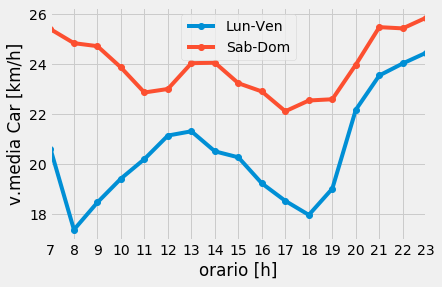

In [4]:
vmedia_week_plot(tragitti[distance_cond & car_cond], 'Car')

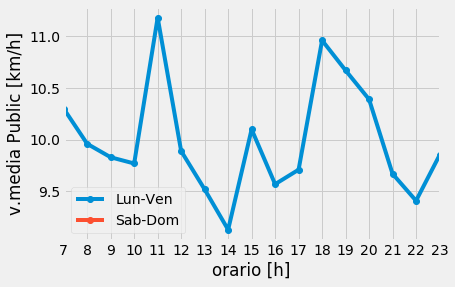

In [5]:
vmedia_week_plot(tragitti[distance_cond & public_cond], 'Public')

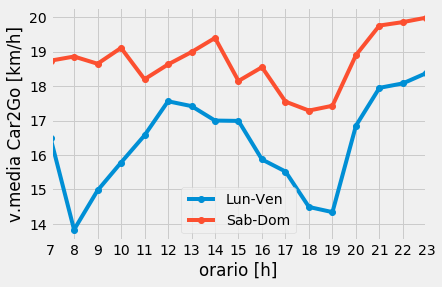

In [6]:
vmedia_week_plot(tragitti[distance_cond & car_cond & car2go_cond & coherence_cond], 'Car2Go')

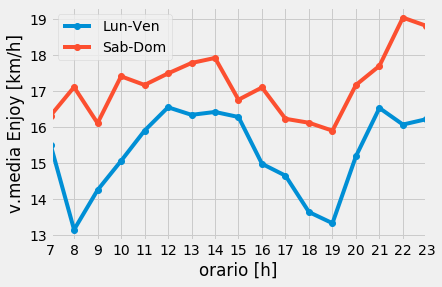

In [7]:
vmedia_week_plot(tragitti[distance_cond & car_cond & enjoy_cond & coherence_cond], 'Enjoy')

In [8]:
# VERIFICO TRAMITE ANOVA CHE LA MEDIA DELLE DISTANZE PROPOSTE
# DAL GENERATORE DI TRATTE SIA UGUALE DA ORA IN ORA
def anova(groups):
    all_elements = pd.concat(groups)
    
    sum_total = sum((all_elements - all_elements.mean())**2)
    sum_within = sum([sum((g - g.mean())**2) for g in groups])
    
    sum_between = sum([len(g) * (g.mean()-all_elements.mean())**2 for g in groups])
    assert(np.abs(sum_total - sum_within - sum_between) < 10**-5)
    n = len(all_elements)
    total_var = sum_total / float(n-1)
    within_var = sum_within / float(n-len(groups))
    
    return (total_var, within_var*(n-len(groups))/(n-1))

def list_of_list(df):
    l = []
    for h in range(7, 24):
        l.append(df[distance_cond & (df['Hour'] == h)]['CDistance'])
    return l

anova(list_of_list(tragitti))

(3.0308837474425512, 3.0213874405003263)